<a href="https://colab.research.google.com/github/sairampolina/Hybrid-Image-Generation-from-scratch/blob/master/Hybrid_image_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [96]:
# Download Data -- run this cell only one time per runtime
!gdown 1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
!unzip "/content/hybrid_pyramid_input.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
To: /content/hybrid_pyramid_input.zip
100% 2.19M/2.19M [00:00<00:00, 168MB/s]
Archive:  /content/hybrid_pyramid_input.zip
   creating: /content/data/
  inflating: /content/data/Afghan_girl_before.jpg  
  inflating: /content/data/motorcycle.bmp  
  inflating: /content/data/cat.bmp   
  inflating: /content/data/makeup_before.jpg  
  inflating: /content/data/fish.bmp  
  inflating: /content/data/bicycle.bmp  
  inflating: /content/data/makeup_after.jpg  
  inflating: /content/data/plane.bmp  
  inflating: /content/data/marilyn.bmp  
  inflating: /content/data/dog.bmp   
  inflating: /content/data/Afghan_girl_after.jpg  
  inflating: /content/data/submarine.bmp  
  inflating: /content/data/bird.bmp  
  inflating: /content/data/einstein.bmp  


# Helper Functions

In [151]:
def read_image(image_path):
  image=cv2.imread(image_path,cv2.IMREAD_COLOR)
  return image

def gaussian_2D_filter(size,cutoff_frequency):

  in_max = (size-1)/2
  arr_x = np.linspace(-in_max,in_max,size)
  arr_y = np.linspace(-in_max,in_max,size)
  x_axis,y_axis = np.meshgrid(arr_x,arr_y)

  # generate 2d gaussian distribution
  normalization=1/(2*np.pi*cutoff_frequency**2)
  filter= (normalization)*np.exp(-0.5*(np.square(x_axis)+np.square(y_axis))/np.square(cutoff_frequency))
  filter = filter/np.sum(filter) 

  # plot the generated 2d gaussian distribution
  fig = plt.figure(figsize=(9, 5))
  ax = plt.axes(projection='3d')
  surf = ax.plot_surface(x_axis, y_axis, filter, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_title('Gaussian 2D plot')
  fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
  ax.view_init(60, 35)

  return filter

def imgfilter(image, filter):
  filtered_image=cv2.filter2D(image,-1,filter)
  return filtered_image

def vis_hybrid_image(hybrid_image):
  scales = 5
  scale_factor = 0.5
  padding = 5
  original_height = hybrid_image.shape[0]
  num_colors = hybrid_image.shape[2] # counting how many color channels the input has
  output = hybrid_image
  cur_image = hybrid_image

  for i in range(2, scales):
      # add padding
      output = np.concatenate((output, np.ones((original_height, padding, num_colors), dtype=int)), axis=1)      
      # dowsample image;
      width = int(cur_image.shape[1] * scale_factor)
      height = int(cur_image.shape[0] * scale_factor)
      dim = (width, height)
      cur_image = cv2.resize(cur_image, dim, interpolation = cv2.INTER_LINEAR)
      # pad the top and append to the output
      tmp = np.concatenate((np.ones((original_height-cur_image.shape[0], cur_image.shape[1], num_colors)), cur_image), axis=0)
      output = np.concatenate((output, tmp), axis=1)
  
  output = (output * 255).astype(np.uint8)
  return output



# Function to compute hybrid images

In [161]:
def compute_hybridimage(path1,path2,cutoff_frequency_,name):

  image_path1 = path1
  image_path2 = path2

  image_1 = read_image(image_path1)
  image_2 = read_image(image_path2)


  # YOUR CODE HERE: TUNE cutoff_frequency
  cutoff_frequency = cutoff_frequency_
  filter_size = int(cutoff_frequency*4+1)

  """cutoff_frequency is the standard deviation, in pixels, of the 
  Gaussian blur that will remove the high frequencies from one image (image_1) and 
  remove the low frequencies from another image (image_2) (to do so, subtract a blurred
  version from the original version). You will want to tune this for every image pair to get the best results."""

  filter = gaussian_2D_filter(filter_size, cutoff_frequency)
  

  """Use imgfilter() to create 'low_frequencies' and 'high_frequencies' and then combine them to create 'hybrid_image'.
  Remove the high frequencies from image_1 by blurring it. The amount of blur that works best will vary with different image pairs."""

  blurred_image1 = imgfilter(image_1, filter)
  low_frequencies = blurred_image1
 

  """Remove the low frequencies from image_2. The easiest way to do this is to
  subtract a blurred version of image_2 from the original version of image_2.
  This will give you an image centered at zero with negative values."""

  blurred_image2 = imgfilter(image_2, filter=filter)

  high_frequencies_negative= np.int16(image_2)-np.int16(blurred_image2)
  high_frequencies=np.uint8(np.clip(high_frequencies_negative,0,255))
 

  """Combine the high frequencies and low frequencies to obtain hybrid_image."""
  hybrid_image=low_frequencies + high_frequencies
  
  """Firstly, visualize low_frequencies, high_frequencies, and the hybrid image."""


  plt.figure(figsize=(7,7))

  # plt.subplot(221)
  # plt.imshow(low_frequencies[:,:,::-1])
  # plt.title("low frequency image")
  
  # plt.subplot(222)
  # plt.imshow(high_frequencies[:,:,::-1])
  # plt.title("high frequency image")


  # plt.subplot(223)
  # plt.imshow(hybrid_image[:,:,::-1])
  # plt.title("hybrid image of "+ name)


 
  # # """Thirdly, visualize hybrid_image_scale using helper function vis_hybrid_image.
  # output=vis_hybrid_image(hybrid_image)
  # plt.subplot(224)
  # plt.imshow(output[:,:,::-1])
  # plt.savefig(f'{name}.png')
  # plt.show()

  plt.imshow(low_frequencies[:,:,::-1])
  plt.title("low frequency image")
  plt.axis('off')
  plt.savefig('low_frequency.png')

  plt.show()

  plt.imshow(high_frequencies[:,:,::-1])
  plt.title("high frequency image")
  plt.axis('off')
  plt.savefig('high_frequency.png')
  plt.show()

  plt.imshow(hybrid_image[:,:,::-1])
  plt.title("hybrid image of "+ name)
  plt.axis('off')
  plt.savefig('hybrid_image.png')
  plt.show()


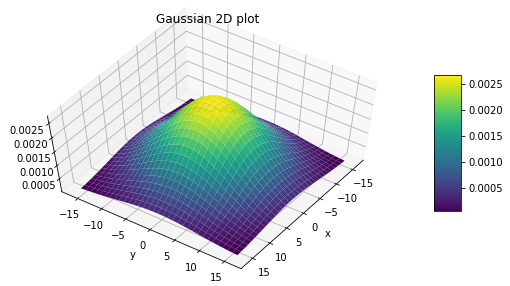

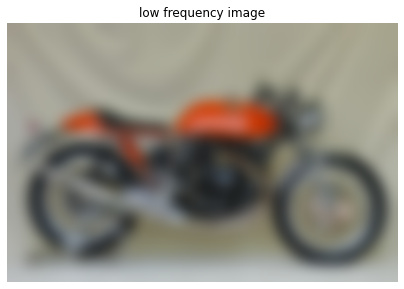

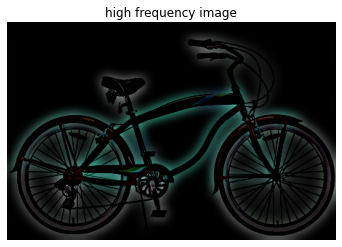

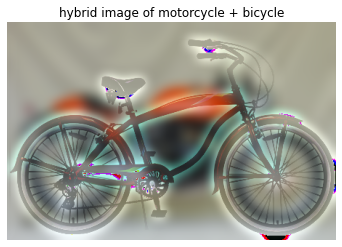

In [162]:
compute_hybridimage('data/motorcycle.bmp','data/bicycle.bmp',8,'motorcycle + bicycle')

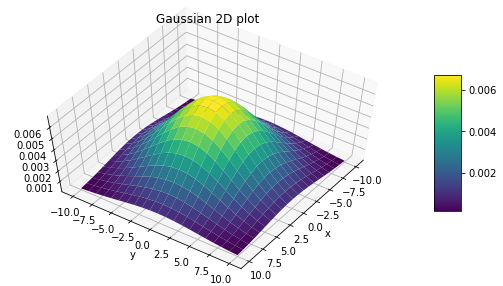

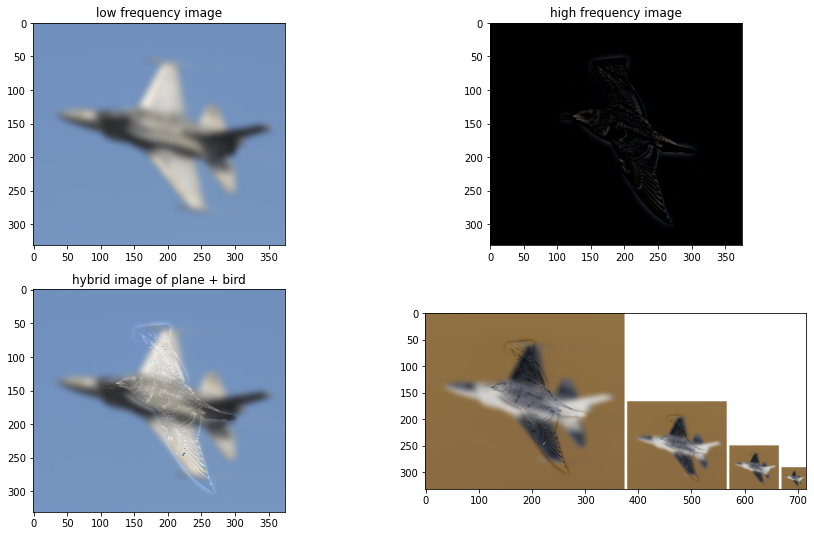

In [158]:
compute_hybridimage('./data/plane.bmp','./data/bird.bmp',5,'plane + bird')